In [1]:
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

def load_dataset(path="data/rent-ideal.csv"):
    dataset = np.loadtxt(path, delimiter=",", skiprows=1)
    y = dataset[:, -1]
    X = dataset[:, 0:- 1]
    return X, y

def gradient_boosting_mse(X, y, num_iter, max_depth=1, nu=0.1):
    """Given predictors X, an array y, and num_iter (big M in the sum)
    
    Set random_state = 0 in your DecisionTreeRegressor() trees.

    Return the y_mean and trees 
   
    Input: X, y, num_iter
           max_depth
           nu (shrinkage parameter)

    Outputs:y_mean, array of trees from DecisionTreeRegressor 
    """
    trees = []
    N, _ = X.shape
    y_mean = np.mean(y)
    fm = y_mean*np.ones(N)
    ### BEGIN SOLUTION
    for i in range(num_iter):
        res = y - fm
        # fit a decision tree on weighted data
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=0)
        tree.fit(X, res)
        trees.append(tree)
        m_preds = tree.predict(X)
        fm = fm + nu*m_preds
        
    ### END SOLUTION
    return y_mean, trees  


def gradient_boosting_predict(X, trees, y_mean, nu=0.1):
    """
    Given X, trees, y_mean predict y_hat
    """
    N, _ = X.shape
    fm = y_mean*np.ones(N)
    for tree in trees:
        m_preds = tree.predict(X)
        fm = fm + nu*m_preds
    y_hat = fm
    return y_hat

In [2]:
X, y = load_dataset()

Set the learning rate to 0.1. Apply gradient boosting to your dataset using different values
for numTrees. How do you find the best value for numTrees? Report the train and
validation R2 for the best value of numTrees. Make a figure which summarizes your
experiment by plotting training and validation R2 as a function of the number of trees. Try
at least 2000 trees

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from tqdm import tqdm

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [4]:
r2_scores = []
val_r2_scores = []
num_trees = list(range(10,2100,50))

for num_iters in tqdm(num_trees):
    y_mean, trees = gradient_boosting_mse(X_train, y_train, num_iter=num_iters, nu=0.1)
    y_train_pred = gradient_boosting_predict(X_train, trees, y_mean, nu=0.1)
    r2_scores.append(r2_score(y_train, y_train_pred))
    val_r2_scores.append(r2_score(y_test, gradient_boosting_predict(X_test, trees, y_mean, nu=0.1)))


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [04:14<00:00,  6.05s/it]


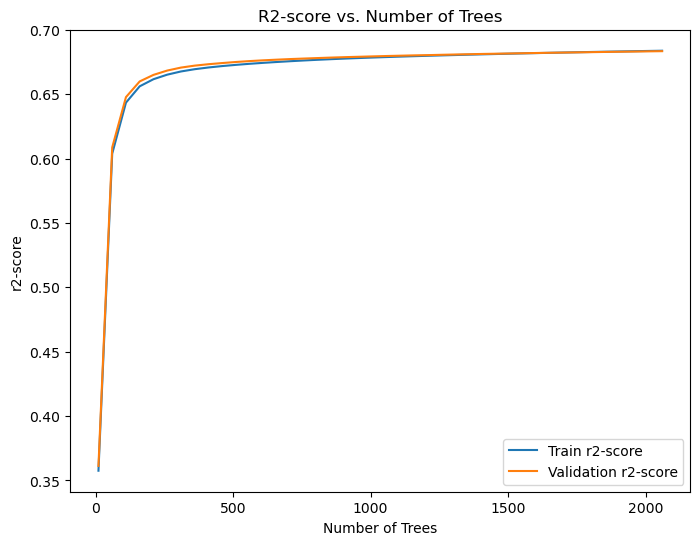

In [5]:
import matplotlib.pyplot as plt

# create a new figure and set its size
fig = plt.figure(figsize=(8, 6))

# create a new axis for the plot
ax = fig.add_subplot(1, 1, 1)

# plot the data using a line plot with markers
ax.plot(num_trees, r2_scores, label='Train r2-score')
ax.plot(num_trees, val_r2_scores, label='Validation r2-score')

# add a legend to the plot
ax.legend()

# add axis labels and a title to the plot
ax.set_xlabel('Number of Trees')
ax.set_ylabel('r2-score')
ax.set_title('R2-score vs. Number of Trees')

# display the plot
plt.show()


As we can see above, increasing num of trees increases the train and validation scores. The grid search led us to the following best number of trees and the best train and validation scores for that num of trees.

In [6]:
num_trees[np.argmax(val_r2_scores)]

2060

In [7]:
r2_scores[np.argmax(val_r2_scores)]

0.6837206530593575

In [8]:
val_r2_scores[np.argmax(val_r2_scores)]

0.6833706393877758

In [9]:
import numpy as np
import pandas as pd
from hyperopt import fmin, tpe, hp, Trials

space = {
    'num_iter': hp.quniform('num_iter', 100, 2100, 50),
}

def objective(params):
    # Train model with given hyperparameters
    y_mean, trees = gradient_boosting_mse(X_train, y_train, num_iter=int(params['num_iter']), nu=0.1)
    # y_train_pred = gradient_boosting_predict(X_train, trees, y_mean, nu=0.1)
    # r2_scores.append(r2_score(y_train, y_train_pred))
    r2 = r2_score(y_test, gradient_boosting_predict(X_test, trees, y_mean, nu=0.1))
    
    # Return loss as the objective value
    return {'loss': -1*r2, 'status': 'ok'}

trials_gbe = Trials()
best = fmin(objective, space, algo=tpe.suggest, max_evals=100, trials=trials_gbe)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [22:12<00:00, 13.33s/trial, best loss: -0.683483790739646]


avg best error: -0.683483790739646


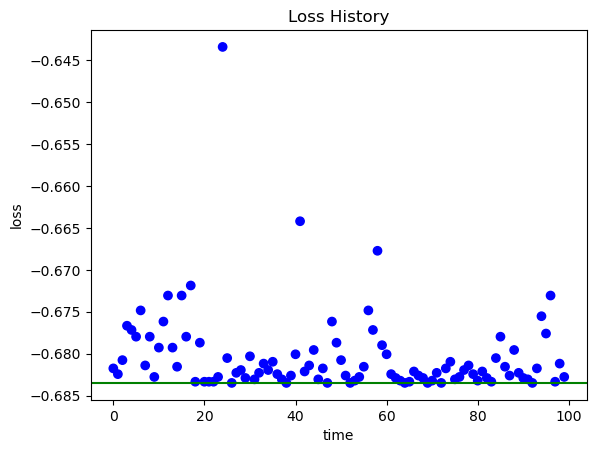

Best hyperparameters: {'num_iter': 2100.0}
Best score: 0.683483790739646


In [10]:
import matplotlib.pyplot as plt
from hyperopt import plotting

# Plot the hyperparameter search history
fig, ax = plt.subplots()
plotting.main_plot_history(trials_gbe)
plt.show()

# Print the best hyperparameters
print("Best hyperparameters:", best)
print("Best score:", -trials_gbe.best_trial['result']['loss'])

In [11]:
results_gbe = pd.DataFrame(trials_gbe.results)
results_gbe['params'] = [t["vals"] for t in trials_gbe.miscs]
results_gbe['loss'] = -results_gbe['loss']

In [21]:
results_gbe.sort_values("loss",ascending=False).head(10)

,loss,status,params
64,0.683484,ok,{'num_iter': [2100.0]}
52,0.683484,ok,{'num_iter': [2100.0]}
92,0.683484,ok,{'num_iter': [2100.0]}
26,0.683484,ok,{'num_iter': [2100.0]}
69,0.683484,ok,{'num_iter': [2100.0]}
72,0.683484,ok,{'num_iter': [2100.0]}
47,0.683484,ok,{'num_iter': [2100.0]}
38,0.683484,ok,{'num_iter': [2100.0]}
65,0.683341,ok,{'num_iter': [2050.0]}
97,0.683341,ok,{'num_iter': [2050.0]}


Using a bayesian optimization based hyperparameter tuning, we can still realise the same conclusion, increasing trees increases the r2 scores.

Compare your results with the results of running the gradient boosting package XGBoost.
Explore the hyperparameters given in the package. Make plots or tables which illustrate
your tuning process and the results of your experiments.

In [13]:
import xgboost as xgb

# Define search space for hyperparameters
space = {
    'max_depth': hp.quniform('max_depth', 3, 10, 1),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.2)),
    'n_estimators': hp.quniform('n_estimators', 100, 1000, 1),
    'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1),
    'subsample': hp.uniform('subsample', 0.5, 1),
    'gamma': hp.uniform('gamma', 0, 1),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1)
}

X_train = X_train
y_train = y_train
X_val = X_test
y_val = y_test
    
def objective(params):
    # Train model with given hyperparameters
    model = xgb.XGBRegressor(
        max_depth=int(params['max_depth']),
        learning_rate=params['learning_rate'],
        n_estimators=int(params['n_estimators']),
        min_child_weight=int(params['min_child_weight']),
        subsample=params['subsample'],
        gamma=params['gamma'],
        colsample_bytree=params['colsample_bytree'],
        random_state=42
    )
    model.fit(X_train, y_train)
    
    # Evaluate model on validation set
    preds = model.predict(X_val)
    r2 = r2_score(y_val, preds)
    
    # Return loss as the objective value
    return {'loss': -1*r2, 'status': 'ok'}


In [14]:
trials = Trials()
best = fmin(objective, space, algo=tpe.suggest, max_evals=100, trials=trials)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [09:51<00:00,  5.92s/trial, best loss: -0.8596336287577326]


avg best error: -0.8596336287577326


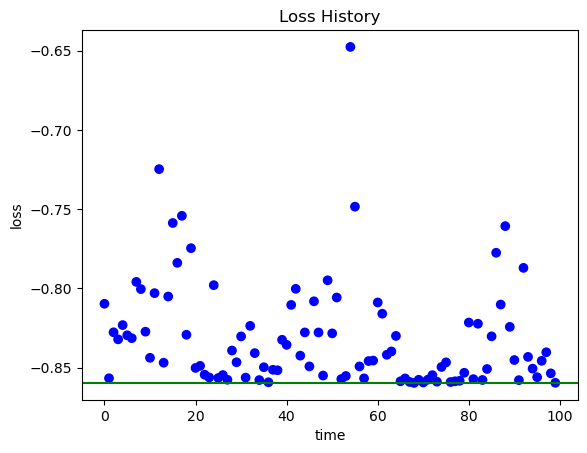

Best hyperparameters: {'colsample_bytree': 0.9433785823184959, 'gamma': 0.7438498714901598, 'learning_rate': 0.09420413640028018, 'max_depth': 10.0, 'min_child_weight': 4.0, 'n_estimators': 663.0, 'subsample': 0.9594715048084557}
Best score: 0.8596336287577326


In [15]:
import matplotlib.pyplot as plt
from hyperopt import plotting

# Plot the hyperparameter search history
fig, ax = plt.subplots()
plotting.main_plot_history(trials)
plt.show()

# Print the best hyperparameters
print("Best hyperparameters:", best)
print("Best score:", -trials.best_trial['result']['loss'])

In [16]:
results_xgb = pd.DataFrame(trials.results)
results_xgb['params'] = [t["vals"] for t in trials.miscs]
results_xgb['loss'] = -results_xgb['loss']

In [23]:
results_xgb.sort_values("loss",ascending=False).head(10)

,loss,status,params
68,0.859634,ok,"{'colsample_bytree': [0.9433785823184959], 'ga..."
99,0.859545,ok,"{'colsample_bytree': [0.9909940187953897], 'ga..."
70,0.859347,ok,"{'colsample_bytree': [0.8665673171402314], 'ga..."
36,0.859223,ok,"{'colsample_bytree': [0.8570215141885268], 'ga..."
76,0.859066,ok,"{'colsample_bytree': [0.9042226562869532], 'ga..."
67,0.859018,ok,"{'colsample_bytree': [0.9460737847430318], 'ga..."
73,0.858872,ok,"{'colsample_bytree': [0.826877470351666], 'gam..."
65,0.858601,ok,"{'colsample_bytree': [0.9613197428218181], 'ga..."
77,0.858591,ok,"{'colsample_bytree': [0.8067673122873098], 'ga..."
78,0.858282,ok,"{'colsample_bytree': [0.8819670213698585], 'ga..."


Best hyperparameters: 
{'colsample_bytree': 0.9433785823184959, 

'gamma': 0.7438498714901598, 

'learning_rate': 0.09420413640028018, 

'max_depth': 10.0, 

'min_child_weight': 4.0, 

'n_estimators': 663.0, 

'subsample': 0.9594715048084557}

Best validation r2-score: 0.8596336287577326

We can see that xgboost, can hit a higher validation r2-score of 0.859 using 663 trees and a variety of regularization and tuning parameters that is listed as optimal above.

We can infer that, xgboost performs better than gradient boosting for the same num of trees, given we can hypertune the rest of the parameters (which takes a while on gridsearch, we saved some time by using bayesian optimization to find a optimal set of hyperparameters)



In [24]:
res = xgb.XGBRegressor().fit(X_train, y_train)

In [28]:
res.score(X_train, y_train)

0.8664509103232718

In [27]:
res.score(X_test, y_test)

0.82749177436228

In [29]:
res

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.300000012, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, ...)

We can also see an out of box xgboost regressor out performs the gradient boosted tree regressor that we had earlier, with just 100 trees.
This also conclusively shows XGBoost is in most cases better than simple gradient boosted regressors due to the underlying XGBoost algorithm, regularization via feature subsampling and sample bootstrapping among other regularization techniques.
